In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/My Drive/Tabular July/

/content/drive/My Drive/Tabular July


In [3]:
import pandas as pd
import seaborn as sb
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
train_df.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


In [25]:
train_df.describe()
train_df.dtypes

date_time                  object
deg_C                     float64
relative_humidity         float64
absolute_humidity         float64
sensor_1                  float64
sensor_2                  float64
sensor_3                  float64
sensor_4                  float64
sensor_5                  float64
target_carbon_monoxide    float64
target_benzene            float64
target_nitrogen_oxides    float64
dtype: object

No null values; target: last 3 columns

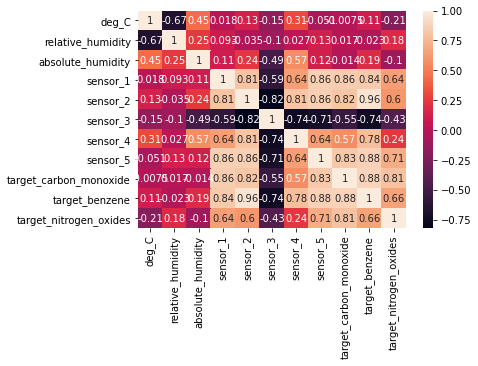

In [15]:
correlation=train_df.corr()
sb.heatmap(correlation, annot=True)

less correlation with sensor_3

In [16]:
x=train_df.drop(["date_time","target_carbon_monoxide","target_benzene","target_nitrogen_oxides"], axis=1)
y1=train_df["target_carbon_monoxide"]

In [21]:
x.head()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4
1,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9
2,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0
3,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2
4,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2


In [20]:
# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


test=SelectKBest(score_func=f_classif, k=4) # sensor1, sensor5, sensor2, sensor3, sensor4, degc, rel_hum, abs_hum
fit = test.fit(x,y1)
print(fit.scores_)

[  3.40686601   3.93857849   1.79567497 244.46488413 198.53452136
  49.10854494  41.63756889 201.76118242]


In [ ]:
from sklearn.feature_selection import RFE # won't work since target is continuous 
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
rfe = RFE(model_lr,3)
fit = rfe.fit(x,y1)
print("Selected Features: %s" % fit.support_)

In [ ]:
from sklearn.decomposition import PCA # not sure how to interpret the output 

pca = PCA(n_components=3)
fit = pca.fit(x)
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

In [29]:
from sklearn.ensemble import ExtraTreesRegressor # ExtraTreesClassifier won't work since target is continuous 

model = ExtraTreesRegressor(n_estimators=10) # sensor_2, sensor_5, sensor1, sensor4, sensor3, deg_c, relative_himdiidy, ab_hum
model.fit(x, y1)
print(model.feature_importances_)

[0.02250211 0.02049993 0.025622   0.18533596 0.43482871 0.02552522
 0.04169179 0.24399427]


In [31]:
x1=train_df.drop(["date_time","target_carbon_monoxide","target_benzene","target_nitrogen_oxides", "deg_C","relative_humidity","absolute_humidity","sensor_4","sensor_3"], axis=1)

In [32]:
x1.head()

,sensor_1,sensor_2,sensor_5
0,1387.2,1087.8,1293.4
1,1279.1,888.2,1010.9
2,1331.9,929.6,1117.0
3,1321.0,929.0,1263.2
4,1272.0,852.7,1132.2


In [44]:
# splits 
from sklearn.neighbors import KNeighborsRegressor
from sklearn import model_selection

model_knn = KNeighborsRegressor()
kfold = model_selection.KFold(n_splits=10)
results = model_selection.cross_val_score(model_knn, x, y1, cv=kfold) # 79% with more features, 78% after feature reduction 
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 79.903% (12.947%)


In [ ]:
loocv = model_selection.LeaveOneOut() # not well defined for less than 2 samples
results = model_selection.cross_val_score(model_knn, x, y1, cv=loocv)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

In [51]:
kfold = model_selection.ShuffleSplit(n_splits=10, test_size=0.33)
results = model_selection.cross_val_score(model_knn, x1, y1, cv=kfold) # 85% with more features, 84% after feature reduction
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 84.130% (1.180%)


Say you have N features, likely reason that your model accuracy drops after n top feature(s) but improves by adding n+k (where n < k < N when features are in descending order based on information gain) is due to inter-dependency (more relevance and less redundancy) of top n and k features. 
solution: use rfe 

In [65]:
# model selection
import numpy as np
from sklearn.tree import DecisionTreeRegressor

kfold = model_selection.ShuffleSplit(n_splits=10, test_size=0.33)
model_tr = DecisionTreeRegressor()
scoring = 'neg_mean_squared_log_error'
results = model_selection.cross_val_score(model_tr, x, y1, cv=kfold, scoring=scoring)
print(np.sqrt(results.mean()))
# with x1: -0.04407255291582824; with x: -0.03553584011922883

nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


In [56]:
results = model_selection.cross_val_score(model_knn, x1, y1, cv=kfold, scoring=scoring)
print(results.mean())
# with x1: -0.026227831917808836 ;with x: -0.023763914280495457

-0.026227831917808836


In [58]:
from sklearn.svm import SVR
model_svr = SVR()
results = model_selection.cross_val_score(model_svr, x, y1, cv=kfold, scoring=scoring)
print(results.mean())
# with x1: -0.023252272902849543 ;with x: -0.021640920886910348

-0.021640920886910348


In [ ]:
# evaluation